In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Embedding, SimpleRNN, Dense, Dropout, TextVectorization, Bidirectional
import pandas as pd
import tensorflow as tf
import random
import os

# RNN #
### Load Data

In [48]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


train_df = pd.read_csv('../data/train.csv', dtype={'text': str, 'label': str})
val_df = pd.read_csv('../data/valid.csv', dtype={'text': str, 'label': str})
test_df = pd.read_csv('../data/test.csv', dtype={'text': str, 'label': str})

train_texts = train_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(str).tolist()

val_texts = val_df['text'].astype(str).tolist()
val_labels = val_df['label'].astype(str).tolist()

test_texts = test_df['text'].astype(str).tolist()
test_labels = test_df['label'].astype(str).tolist()

# Clean texts if theres any NaN or empty strings
train_texts = [text if text and not pd.isna(text) else "" for text in train_texts]
val_texts = [text if text and not pd.isna(text) else "" for text in val_texts]
test_texts = [text if text and not pd.isna(text) else "" for text in test_texts]

vocab_size = 10000
sequence_length = 100
embedding_dim = 100

# Create label map (ensure all labels are accounted for)
unique_labels = set(train_labels + val_labels + test_labels)
label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}

y_train = np.array([label_map[label] for label in train_labels])
y_val = np.array([label_map[label] for label in val_labels])
y_test = np.array([label_map[label] for label in test_labels])

vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    standardize='lower_and_strip_punctuation'
)

vectorizer.adapt(np.array(train_texts))

### Experiment
#### Number of Layers

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3412 - loss: 1.1052 - val_accuracy: 0.4700 - val_loss: 1.0212
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7855 - loss: 0.7776 - val_accuracy: 0.4800 - val_loss: 0.9977
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9593 - loss: 0.4608 - val_accuracy: 0.4900 - val_loss: 1.0734
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9693 - loss: 0.2288 - val_accuracy: 0.4300 - val_loss: 1.1464
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9970 - loss: 0.1070 - val_accuracy: 0.4800 - val_loss: 1.2311
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9964 - loss: 0.0613 - val_accuracy: 0.4600 - val_loss: 1.2371
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9951 - loss: 0.0488 - val_accuracy: 0.4800 - val_loss: 1.2854
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9771 - loss: 0.0734 - val_accuracy: 0.4700 - v

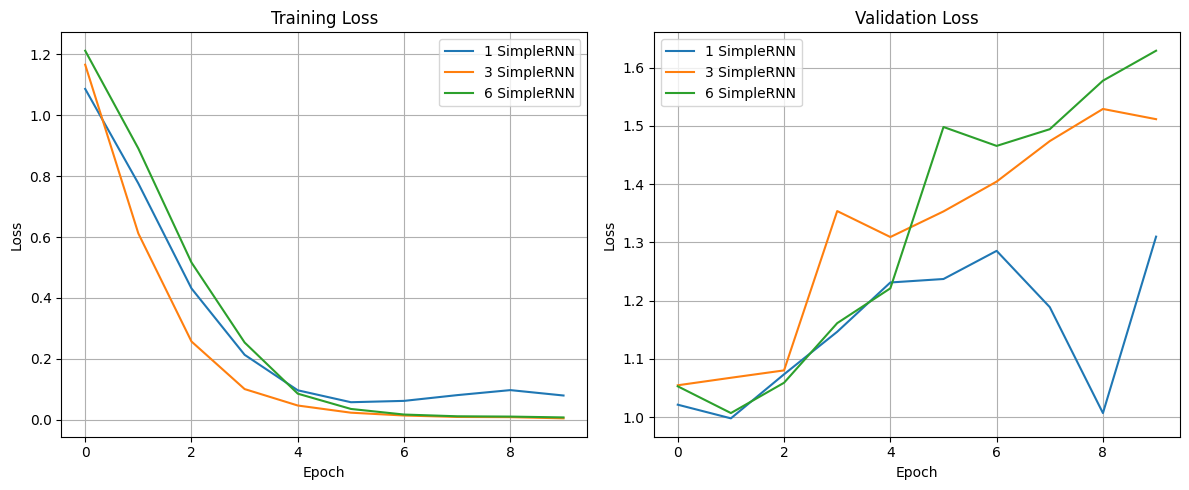

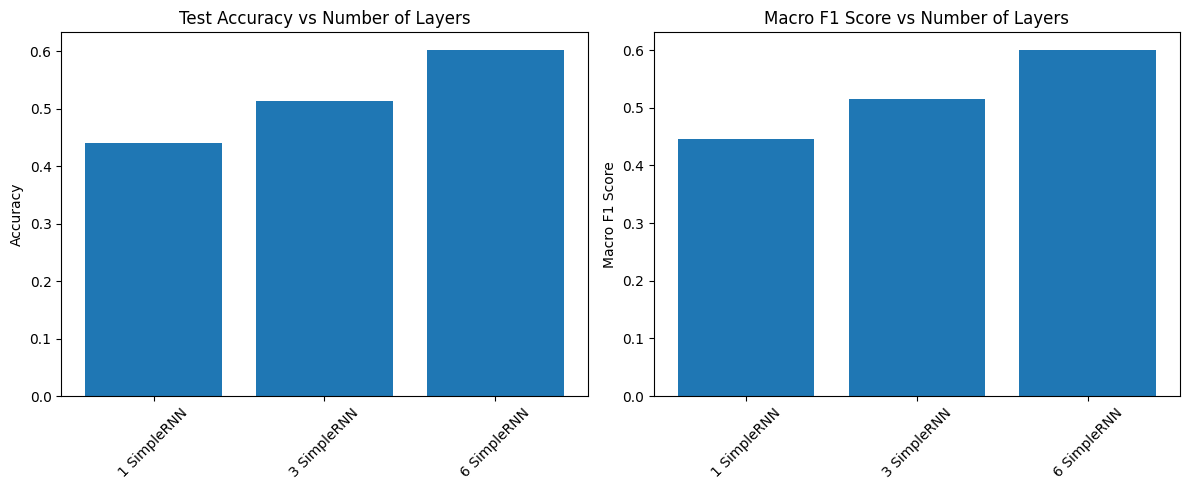

1 SimpleRNN:
  Accuracy: 0.4400
  F1 Score: 0.4453
3 SimpleRNN:
  Accuracy: 0.5125
  F1 Score: 0.5146
6 SimpleRNN:
  Accuracy: 0.6025
  F1 Score: 0.6007


In [52]:
epochs = 10
batch_size = 32

lay = {
    "1 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "3 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "6 SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64, return_sequences=True),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}


accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in lay.items():
    
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(lay.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Number of Layers")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Number of Layers")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

### Number of Cells

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3571 - loss: 1.0998 - val_accuracy: 0.4200 - val_loss: 1.0182
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7043 - loss: 0.8179 - val_accuracy: 0.5400 - val_loss: 0.9637
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8902 - loss: 0.6149 - val_accuracy: 0.5100 - val_loss: 0.9689
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9674 - loss: 0.3526 - val_accuracy: 0.5300 - val_loss: 0.9494
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9989 - loss: 0.1761 - val_accuracy: 0.5900 - val_loss: 0.9613
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1175 - val_accuracy: 0.5900 - val_loss: 1.0308
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0736 - val_accuracy: 0.5700 - val_loss: 1.0726
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9970 - loss: 0.0572 - val_accuracy: 0.5600 - v

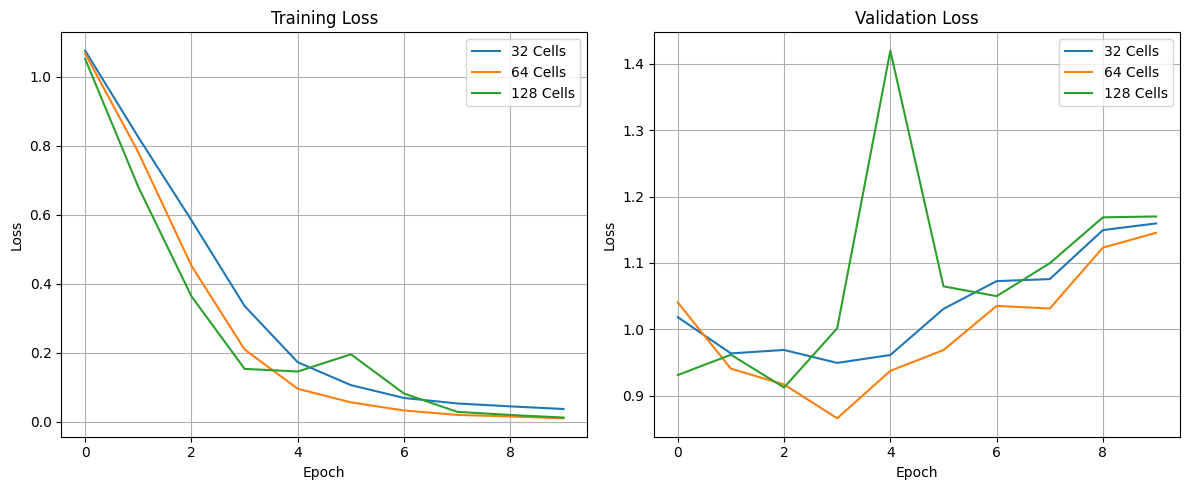

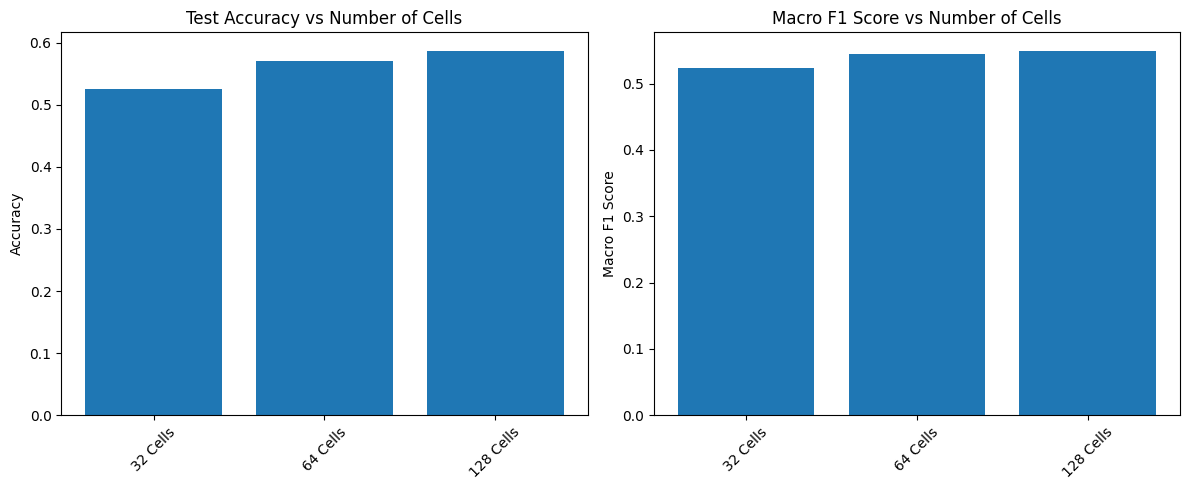

32 Cells:
  Accuracy: 0.5250
  F1 Score: 0.5232
64 Cells:
  Accuracy: 0.5700
  F1 Score: 0.5455
128 Cells:
  Accuracy: 0.5875
  F1 Score: 0.5500


In [54]:
epochs = 10
batch_size = 32

cells = {
    "32 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(32),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "64 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "128 Cells": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(128),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}


accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in cells.items():
    
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)

# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(cells.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Number of Cells")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Number of Cells")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")

### Type of RNN

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4038 - loss: 1.0720 - val_accuracy: 0.5500 - val_loss: 1.0068
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8069 - loss: 0.7450 - val_accuracy: 0.5800 - val_loss: 0.9575
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8779 - loss: 0.5598 - val_accuracy: 0.5700 - val_loss: 0.8615
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9639 - loss: 0.2886 - val_accuracy: 0.5600 - val_loss: 0.8845
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9961 - loss: 0.1562 - val_accuracy: 0.5900 - val_loss: 0.9662
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9982 - loss: 0.0991 - val_accuracy: 0.6500 - val_loss: 0.8700
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0591 - val_accuracy: 0.6600 - val_loss: 0.8361
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9964 - loss: 0.0397 - val_accuracy: 0.6500 - v

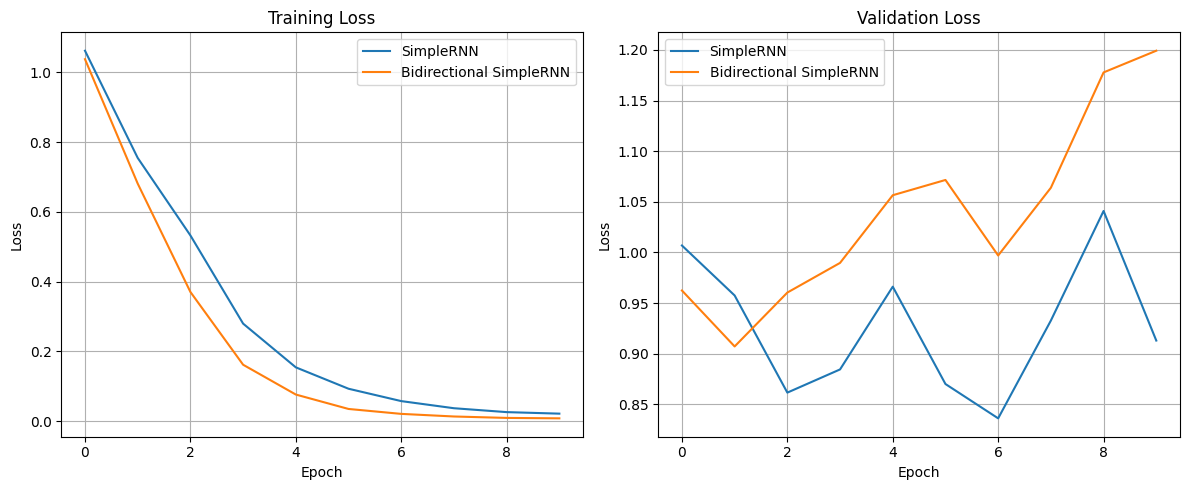

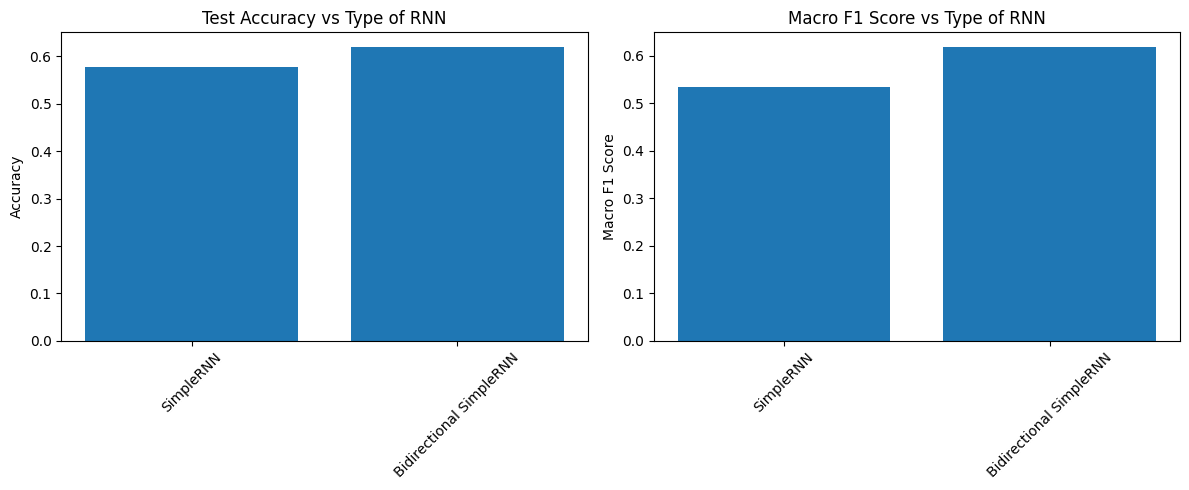

SimpleRNN:
  Accuracy: 0.5775
  F1 Score: 0.5346
Bidirectional SimpleRNN:
  Accuracy: 0.6200
  F1 Score: 0.6186


In [57]:
epochs = 10
batch_size = 32

rnn_types = {
    "SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        SimpleRNN(64),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ],
    "Bidirectional SimpleRNN": [
        vectorizer,
        Embedding(input_dim=vocab_size + 1,
                  output_dim=embedding_dim,
                  mask_zero=True,
                  embeddings_initializer='uniform'),
        Bidirectional(SimpleRNN(64)),
        Dropout(0.5, seed=SEED),
        Dense(len(label_map), 
              activation='softmax')
    ]
}

accuracy = []
train_loss = {}
val_loss = {}
f1_scores = []

for name, layers in rnn_types.items():
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    
    model = Sequential(layers)
    
    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer='adam',
        metrics=["accuracy"]
    )
    
    history = model.fit(
        np.array(train_texts, dtype=object),
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(np.array(val_texts, dtype=object), y_val),
        verbose=1,
        shuffle=True
    )
    
    train_loss[name] = history.history["loss"]
    val_loss[name] = history.history["val_loss"]
    
    score = model.evaluate(np.array(test_texts, dtype=object), y_test, verbose=0)
    accuracy.append(score[1])
    
    y_pred = model.predict(np.array(test_texts, dtype=object), verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    f1 = f1_score(y_test.flatten(), y_pred_classes, average='macro')
    f1_scores.append(f1)
    
# Plot training loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for name, tl in train_loss.items():
    plt.plot(tl, label=name)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

# Plot validation loss
plt.subplot(1, 2, 2)
for name, vl in val_loss.items():
    plt.plot(vl, label=name)
    
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
names = list(rnn_types.keys())
plt.bar(names, accuracy)
plt.title("Test Accuracy vs Type of RNN")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

# Plot F1 score comparison
plt.subplot(1, 2, 2)
plt.bar(names, f1_scores)
plt.title("Macro F1 Score vs Type of RNN")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, acc, f1 in zip(names, accuracy, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1 Score: {f1:.4f}")